In [295]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.io.wavfile, scipy.fft, scipy.signal
import IPython

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# I. Note onset detection

Before detecting pitch, we first pick out timestamps of the onsets of the notes in the audio. This way, we "mark" where the notes are so that we can focus our attention on small slices of the audio around those points, ignoring other parts of the audio which are less eventful.

For example, there are nine notes in this audio clip (Beethoven Piano Sonata No. 31, 3rd mvt., fugue theme), and we want to mark the onset of each of these.

In [298]:
IPython.display.Audio("yamaha/LvB_fugue_theme.wav")

Our approach involves picking out peaks in the raw audio waveform. Since each note produces a new sound, this tends to correlate to a spike in the audio. We're interested in these macro-level peaks:

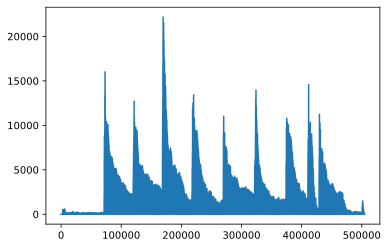

In [302]:
sample_rate, data = scipy.io.wavfile.read('yamaha/LvB_fugue_theme.wav')
data = np.abs(data)
plt.plot(data);

But there are many other peaks (on the "micro"-level) caused by the sinusoidal nature of sound. We can see these micro-level peaks if we zoom in on a small part of the audio:

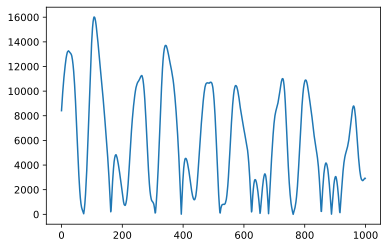

In [312]:
plt.plot(data[73000:74000]);

We want to work with a "zoomed out" version the audio so that we only see the macro-level peaks and ignore the micro-level ones. To do this, we can slide a window over the waveform, take the maximum amplitude of the audio within that window, and discard the rest of the data. This achieves "zooming out" in a sense by hiding the micro-level movements in the waveform and keeps only the general, macro trend.

The `condensed()` function performs this step, returning the condensed data (orange line in the graph below) as well as timestamps in the original audio corresponding to the maximums of each window to be used later (green dots in the graph below).

In [263]:
def condensed(data, window_size):
    padded = np.pad(data, (0, (window_size - len(data) % window_size) % window_size))
    reshaped = padded.reshape((-1, window_size))
    return reshaped.max(axis = 1), reshaped.argmax(axis = 1) + np.arange(0, len(data), window_size)

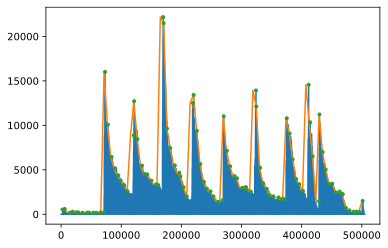

In [313]:
c, i = condensed(data, 5500)
plt.plot(data)
plt.plot(np.arange(0, len(data), 5500), c)
plt.plot(i, data[i], '.');

Finally, we can pick out the peaks from the orange line (keeping only ones that are above a certain threshold) and, if necessary, merge adjacent peaks that are too close together.

In [314]:
def splits(data, threshold = 5000, condense_window = 2205):
    data = np.abs(data)
    data, peaks = condensed(data, condense_window)
    for i in range(1, len(data) - 1):
        if (data[i-1] < data[i] > data[i+1] and data[i] > threshold):
            yield peaks[i]

In [315]:
def merge_peaks(peaks, merge_window = 4410):
    prev = -merge_window
    for p in peaks:
        if p >= prev + merge_window:
            yield p
        prev = p

Final result for onset detection:

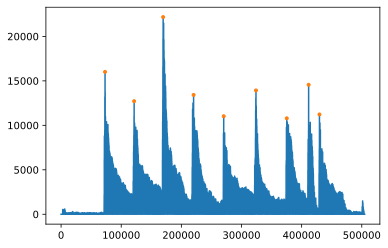

In [316]:
plt.plot(data)
markers = [s for s in merge_peaks(splits(data, condense_window = 5500), merge_window = 10000)]
plt.plot(markers, data[markers], '.');

# II. Pitch Detection

We're using a Fourier Transform based approach to determine which notes are played. After picking out the onsets of each note, we find the FT of a small window starting at that onset.

In [262]:
def sharpened(data, filter_size = 2, threshold = 0.1):
    s_filter = np.full(2 * filter_size + 1, -1 / filter_size)
    s_filter[filter_size] = 1
    sharp = np.copy(data)
    sharp[scipy.signal.convolve(data, s_filter, mode = 'same') < threshold] = 0
    return sharp

In [264]:
def normalized(data):
    return data / np.max(data)

In [267]:
def fourier_transform(data, sample_rate, cutoff_freq = 1000):
    fourier = scipy.fft.fft(data)
    freqs = scipy.fft.fftfreq(len(data), d = 1 / sample_rate)
    return fourier[:cutoff_freq], freqs[:cutoff_freq]

In [268]:
def freq_upperbound(freqs, ft, ignore_threshold = 100):
    prev = 0
    ub = 22050
    for i in range(len(ft)):
        if ft[i] > 0 and freqs[i] - freqs[prev] > ignore_threshold:
            ub = min(ub, freqs[i] - freqs[prev])
            prev = i
    return ub

In [269]:
def octave_correction(references, ft, freqs, note):
    this_freq = freq_upperbound(freqs, ft)
    ratio = round(np.log2(this_freq / freq_upperbound(freqs, references[note%12])))
    return note % 12 + ratio * 12

In [270]:
def get_note(references, magnitudes, freqs, ft):
    projected = np.dot(references, ft) / magnitudes
    note = np.argmax(projected)
    if projected[note] == 0: return -1;
    return octave_correction(references, ft, freqs, note)

In [271]:
def get_principal_note(ref_fts, ref_mags, this):
    projected = np.dot(ref_fts, this) / ref_mags
    principal_note = np.argmax(projected)
    principal_freq = np.argmax(ref_fts[principal_note])
    coefficient = this[principal_freq] / ref_fts[principal_note][principal_freq]
    if coefficient == 0:
        return -1, 0, None
    return principal_note, projected[principal_note], this - coefficient * ref_fts[principal_note]

"Learn" the transforms of each note by averaging their sharpened versions.

In [339]:
ref_fts = []
sample_duration = 4400
n = 1
for f, thresh in [('med.wav', 5000)]:
    sample_rate, data = scipy.io.wavfile.read('yamaha/' + f)
    onsets = [s for s in merge_peaks(splits(data, threshold = thresh, condense_window = 5500), merge_window = 10000)]
    notes = [fourier_transform(data[o:o+sample_duration], sample_rate, 1200) for o in onsets]
    for j, (ft, freqs) in enumerate(notes):
        s = sharpened(normalized(np.abs(ft)))
        if j >= len(ref_fts):
            ref_fts.append(np.zeros(len(freqs)))
        ref_fts[j] += s / n
ref_mags = np.sum(np.square(ref_fts), axis = 1)

261.81818181818176


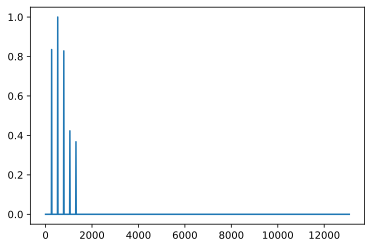

In [354]:
plt.plot(freqs, ref_fts[12])
print(freq_upperbound(freqs, ref_fts[12]))

In [392]:
sample_rate, data = scipy.io.wavfile.read('yamaha/portal.wav')
# onsets = [s for s in merge_peaks(splits(data, condense_window = 5500), merge_window = 5500)]
onsets = list(range(0, len(data)-2200, 2200))
notes = [fourier_transform(data[o:o+sample_duration], sample_rate, 1200)[0] for o in onsets]

In [393]:
mapping = 'C D♭ D E♭ E F G♭ G A♭ A B♭ B'.split()
note_colors = '''#ffb8b8 #ffc8b8 #ffdcb8 #fff1b8 #fffdb8 #dcffb8 #b8ffc0
                 #b8f8ff #b8e1ff #b8cdff #b8baff #e7b8ff #ffb8e0'''.split()

Taking the dot product of each possible note with the input note (projecting the input onto each of these vectors) to find the most similar one.

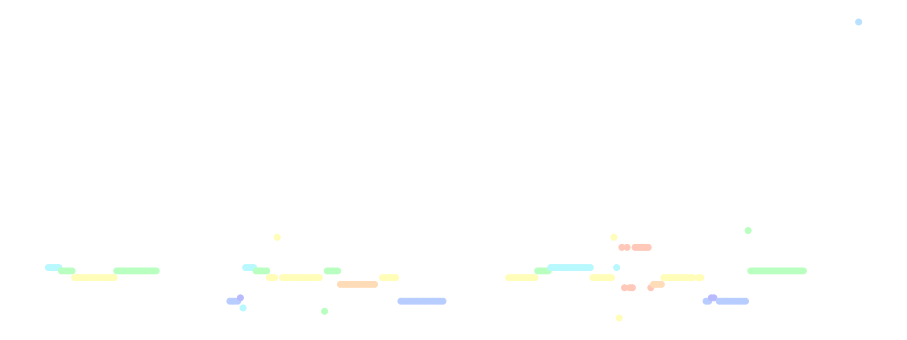

In [394]:
fig = plt.figure(figsize = (len(data) // 44100, len(ref_fts) // 12 * 3))
plt.axis('off')
for i in range(len(notes)):
    if np.max(np.abs(notes[i])) < 1000000: continue;
    this = sharpened(normalized(np.abs(notes[i])))
    note = get_note(ref_fts, ref_mags, freqs, this)
    if note != -1:
#         plt.scatter(onsets[i], note, s = 1500, marker = '_', color = note_colors[note % 12], linewidth = 15)
        plt.scatter(onsets[i], note, color = note_colors[note % 12])
        #plt.annotate(mapping[note % 12], (onsets[i] - 10, note), va = 'center', ha = 'center')

In [155]:
slices = [1] * 12
wp = {'width': 0.3}
inactive = ['#ededed'] * 12

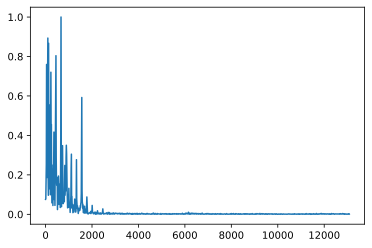

In [375]:
plt.plot(freqs, normalized(np.abs(notes[175])))

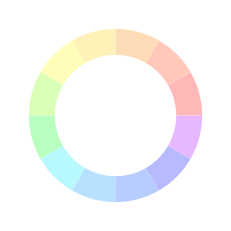

In [156]:
plt.pie(slices, wedgeprops = wp, colors = note_colors);

In [246]:
sample_rate, data = scipy.io.wavfile.read('yamaha/chords.wav')
onsets = [s for s in merge_peaks(splits(data, threshold = 10000, condense_window = 5500), merge_window = 10000)]
notes = [fourier_transform(data[o:o+sample_duration], sample_rate, 1200)[0] for o in onsets]

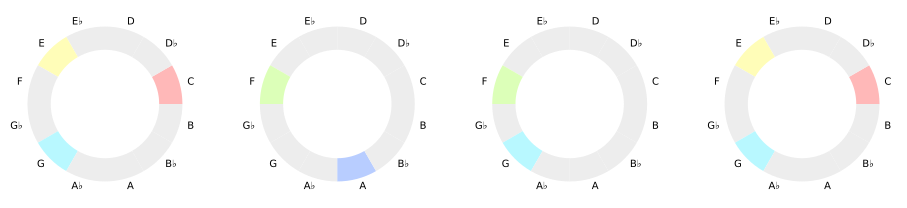

In [247]:
fig = plt.figure(figsize = (16, 16 * len(notes)))
for i in range(len(notes)):
    this = sharpened(normalized(np.abs(notes[i])))
    principal, component, remainder = get_principal_note(ref_fts, ref_mags, this)
    palette = inactive[:]
    while component > 0.2:
        palette[principal % 12] = note_colors[principal % 12]
        principal, component, remainder = get_principal_note(ref_fts, ref_mags, remainder)
    fig.add_subplot(1, len(notes), i+1).pie(slices, wedgeprops = wp, labels = mapping, colors = palette)